### Riiid Answer Correctness Prediction 
https://www.kaggle.com/c/riiid-test-answer-prediction

In this competition, your challenge is to create algorithms for "Knowledge Tracing," the modeling of student knowledge over time. The goal is to accurately predict how students will perform on future interactions. You will pair your machine learning skills using Riiid’s EdNet data.

Inspired by: https://www.kaggle.com/erikbruin/riiid-comprehensive-eda-baseline/notebook

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/riiid-train-data-multiple-formats/riiid_train.pkl.gzip
/kaggle/input/riiid-train-data-multiple-formats/riiid_train.parquet
/kaggle/input/riiid-train-data-multiple-formats/riiid_train.feather
/kaggle/input/riiid-train-data-multiple-formats/riiid_train.h5
/kaggle/input/riiid-train-data-multiple-formats/riiid_train.jay
/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py
/kaggle/input/riiid-cross-validation-files/cv3_valid.pickle
/kaggle/input/riiid-cross-validation-files/cv1_train.pickle
/kaggle/input/riiid-cross-validation-files/cv3_train.pickle
/kaggle/input/rii

The code imports libraries such as numpy, pandas, matplotlib, and seaborn, which are commonly used in data science projects.

Then, it sets the style of the plots to the "fivethirtyeight" style using matplotlib, and defines a formatter function to customize the tick labels in the plot.

Finally, it checks the files available in the input directory, which is a read-only directory where the input data is stored.

The last two comments explain the write permissions and the possibility of creating temporary files in the working and temp directories, respectively.

In [ ]:
%%time

train = pd.read_pickle("../input/riiid-train-data-multiple-formats/riiid_train.pkl.gzip")
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('boolean')
print("Train size:", train.shape)

Train size: (101230332, 10)
CPU times: user 36.4 s, sys: 12.1 s, total: 48.5 s
Wall time: 1min 17s


This code reads a large pickle file containing training data for a machine learning model. The `%%time` magic command is used to measure the time taken to execute the code block. 

The `pd.read_pickle()` function from pandas library is used to read the pickle file, which is compressed using gzip. The file path is given as the argument to the function. 

After reading the file, the code converts the 'prior_question_had_explanation' column to boolean data type, which could be a binary flag indicating whether the user saw an explanation for the previous question or not.

Finally, the code prints the shape of the `train` dataframe to check the number of rows and columns.

In [ ]:
train.memory_usage(deep=True)

Index                                   128
row_id                            809842656
timestamp                         809842656
user_id                           404921328
content_id                        202460664
content_type_id                   101230332
task_container_id                 202460664
user_answer                       101230332
answered_correctly                101230332
prior_question_elapsed_time       404921328
prior_question_had_explanation    202460664
dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 bool   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
dtypes: bool(1), boolean(1), float32(1), int16(2), int32(1), int64(2), int8(2)
memory usage: 3.1 GB


In [ ]:
%%time

questions = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')
lectures = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/lectures.csv')
example_test = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_test.csv')
example_sample_submission = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv')

CPU times: user 15.1 ms, sys: 8.35 ms, total: 23.5 ms
Wall time: 66.3 ms


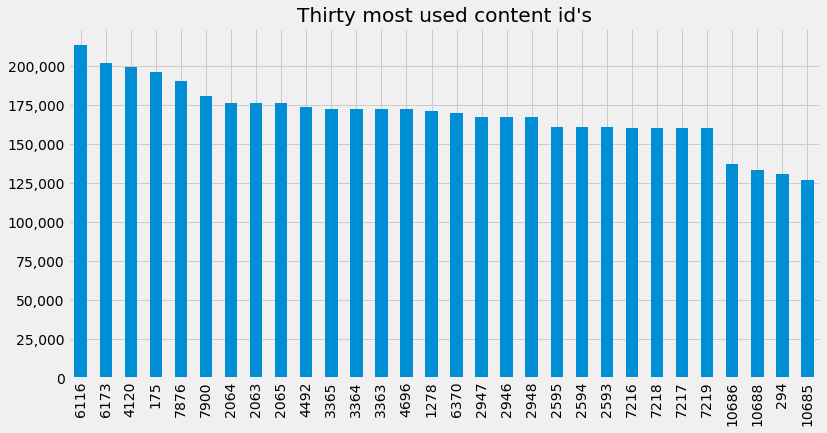

In [ ]:
cids = train.content_id.value_counts()[:30]

fig = plt.figure(figsize=(12,6))
ax = cids.plot.bar()
plt.title("Thirty most used content id's")
plt.xticks(rotation=90)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()

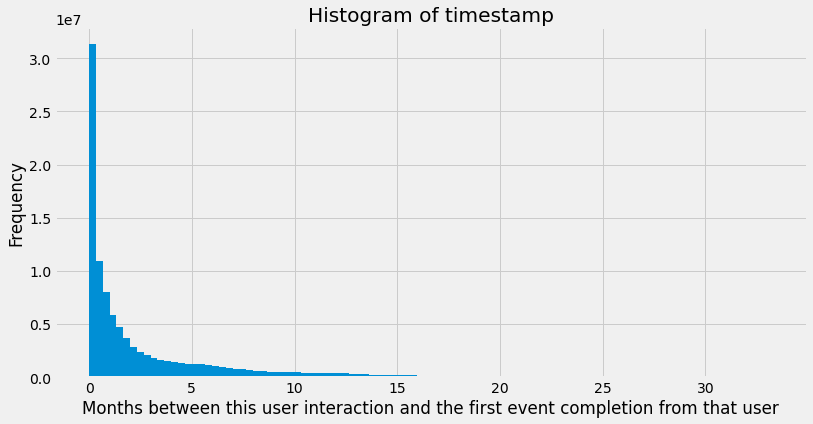

In [ ]:
#1 year = 31536000000 ms
ts = train['timestamp']/(31536000000/12)
fig = plt.figure(figsize=(12,6))
ts.plot.hist(bins=100)
plt.title("Histogram of timestamp")
plt.xticks(rotation=0)
plt.xlabel("Months between this user interaction and the first event completion from that user")
plt.show()

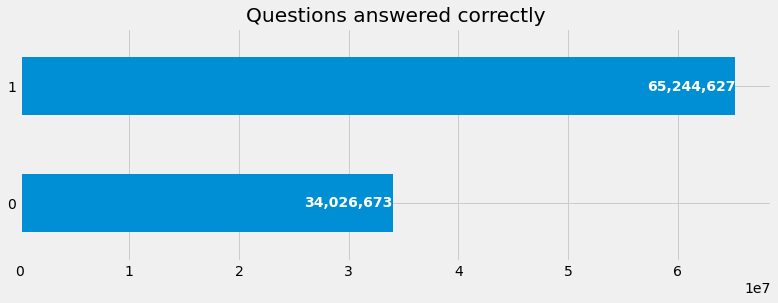

In [ ]:
correct = train[train.answered_correctly != -1].answered_correctly.value_counts(ascending=True)

fig = plt.figure(figsize=(12,4))
correct.plot.barh()
for i, v in zip(correct.index, correct.values):
    plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Questions answered correctly")
plt.xticks(rotation=0)
plt.show()

In [ ]:
user_percent = train[train.answered_correctly != -1].groupby('user_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'the highest number of questions answered by a user is {user_percent.Answers.max()}')

the highest number of questions answered by a user is 17609


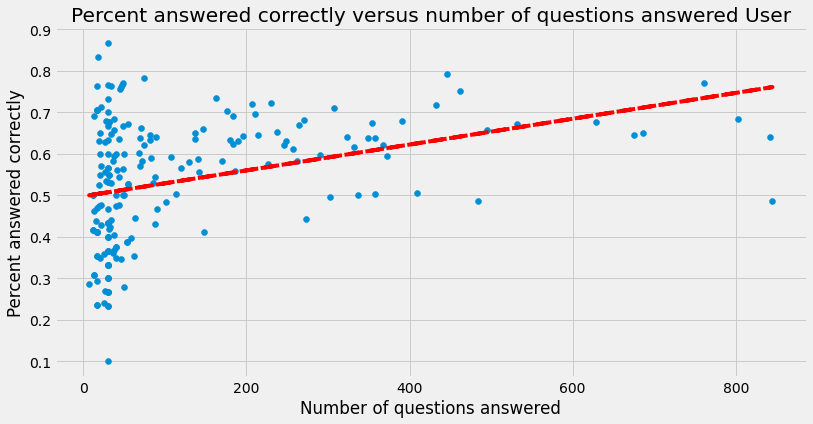

In [ ]:
user_percent = user_percent.query('Answers <= 1000').sample(n=200, random_state=1)

fig = plt.figure(figsize=(12,6))
x = user_percent.Answers
y = user_percent.Mean
plt.scatter(x, y, marker='o')
plt.title("Percent answered correctly versus number of questions answered User")
plt.xticks(rotation=0)
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

### Test data

In [ ]:
example_test.shape

(104, 11)

In [ ]:
example_test.head()

,row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
0,0,0,0,275030867,5729,0,0,NaN,NaN,[],[]
1,1,0,13309898705,554169193,12010,0,4427,19000.0,True,NaN,NaN
2,2,0,4213672059,1720860329,457,0,240,17000.0,True,NaN,NaN
3,3,0,62798072960,288641214,13262,0,266,23000.0,True,NaN,NaN
4,4,0,10585422061,1728340777,6119,0,162,72400.0,True,NaN,NaN


In [ ]:
batches_test = set(list(example_test.task_container_id.unique()))
batches_train = set(list(train.task_container_id.unique()))
print(f'All batches in example_test are also in train is {batches_test.issubset(batches_train)}.')

All batches in example_test are also in train is True.


In [ ]:
user_test = set(list(example_test.user_id.unique()))
user_train = set(list(train.user_id.unique()))

print(f'User_ids in example_test but not in train: {user_test - user_train}.')

User_ids in example_test but not in train: {275030867}.


### Baseline model

In [ ]:
#this clears everything loaded in RAM, including the libraries
%reset -f

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/riiid-train-data-multiple-formats/riiid_train.pkl.gzip
/kaggle/input/riiid-train-data-multiple-formats/riiid_train.parquet
/kaggle/input/riiid-train-data-multiple-formats/riiid_train.feather
/kaggle/input/riiid-train-data-multiple-formats/riiid_train.h5
/kaggle/input/riiid-train-data-multiple-formats/riiid_train.jay
/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py
/kaggle/input/riiid-cross-validation-files/cv3_valid.pickle
/kaggle/input/riiid-cross-validation-files/cv1_train.pickle
/kaggle/input/riiid-cross-validation-files/cv3_train.pickle
/kaggle/input/rii

This code block lists all the files and directories in the `/kaggle/input` directory. 

The `os.walk()` function is used to traverse the directory tree, starting from the given directory path. It returns a tuple of three values for each directory it visits: the path to the directory, a list of subdirectories, and a list of files.

The loop iterates through each filename in the list of files and prints the full path to the file using the `os.path.join()` function. 

This code can be useful to check if the required input files are present in the directory or to locate the path of a file that needs to be read.

In [ ]:
import sys
sys.path.append('/kaggle/input/riiid-test-answer-prediction')
import riiideducation

This code block imports a module named `riideducation` from the file `riiideducation.py`, which is located in the `/kaggle/input/riiid-test-answer-prediction` directory. 

The `sys.path.append()` function adds the specified directory to the system path, which tells Python where to search for modules to import. This is necessary because the file is located in a directory other than the current working directory. 

After importing the module, it can be used to simulate the test environment for the Riiid AIEd Challenge on Kaggle, which is a competition that requires participants to develop algorithms that can predict student responses to future interactions in an educational platform. The `riideducation` module provides functions to simulate the data pipeline and evaluation of the models.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc
import sys
pd.set_option('display.max_rows', None)

This code block imports several libraries for data analysis, visualization, and machine learning:

- `numpy` and `pandas` are used for data manipulation and analysis.
- `matplotlib` and `seaborn` are used for data visualization.
- `lightgbm` is a gradient boosting framework for machine learning.
- `sklearn` is a machine learning library that provides various algorithms and tools for data preprocessing, model selection, and evaluation.

The `gc` module is used for garbage collection, which is a process of freeing up the memory used by unused objects in the code. 

The `pd.set_option()` function is used to set the maximum number of rows to display in the output of pandas dataframes. In this case, the `None` value means that all rows will be displayed.

In [ ]:
%%time
cols_to_load = ['row_id', 'user_id', 'answered_correctly', 'content_id', 'prior_question_had_explanation', 'prior_question_elapsed_time']
train = pd.read_pickle("../input/riiid-train-data-multiple-formats/riiid_train.pkl.gzip")[cols_to_load]
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('boolean')

print("Train size:", train.shape)

Train size: (101230332, 6)
CPU times: user 39.8 s, sys: 9.99 s, total: 49.8 s
Wall time: 1min


This code block is similar to the one we discussed earlier. It reads a large pickle file containing training data for a machine learning model. 

The `cols_to_load` list specifies the columns to load from the file. This can be useful when dealing with large datasets where not all columns are needed for analysis or modeling.

The `%%time` magic command is used to measure the time taken to execute the code block.

The `pd.read_pickle()` function is used to read the pickle file, and only the specified columns are loaded into the `train` dataframe. 

After reading the file, the code converts the 'prior_question_had_explanation' column to boolean data type, which could be a binary flag indicating whether the user saw an explanation for the previous question or not.

Finally, the code prints the shape of the `train` dataframe to check the number of rows and columns.

In [ ]:
%%time

questions = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')
lectures = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/lectures.csv')
example_test = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_test.csv')
example_sample_submission = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv')

CPU times: user 13.8 ms, sys: 1.92 ms, total: 15.7 ms
Wall time: 25.6 ms


In [ ]:
print(train.shape)
train.head()

(101230332, 6)


,row_id,user_id,answered_correctly,content_id,prior_question_had_explanation,prior_question_elapsed_time
0,0,115,1,5692,<NA>,NaN
1,1,115,1,5716,False,37000.0
2,2,115,1,128,False,55000.0
3,3,115,1,7860,False,19000.0
4,4,115,1,7922,False,11000.0


In [ ]:
%%time
#adding user features
user_df = train[train.answered_correctly != -1].groupby('user_id').agg({'answered_correctly': ['count', 'mean']}).reset_index()
user_df.columns = ['user_id', 'user_questions', 'user_mean']

user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
user_lect.columns = ['Lecture', 'Wrong', 'Right']
user_lect = user_lect[['Lecture']].fillna(0).astype('int8')
#user_lect = user_lect.astype('int8')
user_lect['watches_lecture'] = np.where(user_lect.Lecture > 0, 1, 0)
user_lect = user_lect.reset_index()
user_lect = user_lect[['user_id', 'watches_lecture']]

user_df = user_df.merge(user_lect, on = "user_id", how = "left")
del user_lect
user_df.head()

CPU times: user 11.9 s, sys: 5.07 s, total: 17 s
Wall time: 17 s


,user_id,user_questions,user_mean,watches_lecture
0,115,46,0.695652,0
1,124,30,0.233333,0
2,2746,19,0.578947,1
3,5382,125,0.672000,1
4,8623,109,0.642202,1


This code block creates new user-level features based on the training data. The `train` dataframe contains information about the interactions between users and questions, including whether a user answered a question correctly, the content ID of the question, whether the user saw an explanation for the previous question, and how much time elapsed between the previous question and the current question.

The code first filters out rows where `answered_correctly` is `-1`. These are lecture events, not question events, so they are not relevant for computing user-level features.

Next, the code groups the remaining rows by `user_id` and aggregates the `answered_correctly` column by counting the number of questions answered by each user and computing the mean accuracy of the user's answers.

The resulting dataframe is renamed to `user_df` with columns `user_id`, `user_questions`, and `user_mean`.

The code then creates a new dataframe `user_lect` by grouping the `train` dataframe by `user_id` and `answered_correctly`. It computes the number of lectures, wrong answers, and right answers for each user, then selects the `Lecture` column and fills missing values with 0. The `Lecture` column is then converted to an integer data type and a new `watches_lecture` column is created, which is 1 if the user watched at least one lecture, and 0 otherwise.

The resulting `user_lect` dataframe is then merged with the `user_df` dataframe on `user_id`, using a left join to keep all users in the `user_df` dataframe. The resulting `user_df` dataframe now includes a new column `watches_lecture`, indicating whether each user watched at least one lecture.

Finally, the `user_lect` dataframe is deleted to free up memory.

In [ ]:
%%time
#adding content features
content_df = train[train.answered_correctly != -1].groupby('content_id').agg({'answered_correctly': ['count', 'mean']}).reset_index()
content_df.columns = ['content_id', 'content_questions', 'content_mean']
content_df.head()

CPU times: user 7.32 s, sys: 2.27 s, total: 9.59 s
Wall time: 9.59 s


,content_id,content_questions,content_mean
0,0,6903,0.907721
1,1,7398,0.890646
2,2,44905,0.554281
3,3,22973,0.779437
4,4,31736,0.613215


In [ ]:
%%time
#using one of the validation sets composed by tito
cv2_train = pd.read_pickle("../input/riiid-cross-validation-files/cv2_train.pickle")['row_id']
cv2_valid = pd.read_pickle("../input/riiid-cross-validation-files/cv2_valid.pickle")['row_id']

CPU times: user 2.32 s, sys: 8.84 s, total: 11.2 s
Wall time: 51.8 s


In [ ]:
train = train[train.answered_correctly != -1]

#save mean before splitting
#please be aware that there is an issues with train.prior_question_elapsed_time.mean()
#see https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/195032
mean_prior = train.prior_question_elapsed_time.astype("float64").mean()

validation = train[train.row_id.isin(cv2_valid)]
train = train[train.row_id.isin(cv2_train)]

validation = validation.drop(columns = "row_id")
train = train.drop(columns = "row_id")

del cv2_train, cv2_valid
gc.collect()

97

In [ ]:
def data_pipeline(df, user_df, content_df, label_enc, mode='train'):
    df = df.merge(user_df, on = "user_id", how = "left")
    df = df.merge(content_df, on = "content_id", how = "left")
    df['content_questions'].fillna(0, inplace = True)
    df['content_mean'].fillna(0.5, inplace = True)
    df['watches_lecture'].fillna(0, inplace = True)
    df['user_questions'].fillna(0, inplace = True)
    df['user_mean'].fillna(0.5, inplace = True)
    df['prior_question_elapsed_time'].fillna(mean_prior, inplace = True)
    df['prior_question_had_explanation'].fillna(False, inplace = True)

    if mode =='train':
        label_enc.fit(df['prior_question_had_explanation'])

    df['prior_question_had_explanation'] = label_enc.transform(df['prior_question_had_explanation'])    
    df[['content_questions', 'user_questions']] = df[['content_questions', 'user_questions']].astype(int)
    return df, label_enc

This function takes in several data frames, an encoder, and a mode. It merges the data frames and encodes the `prior_question_had_explanation` column, fills in any missing values, and returns the resulting data frame along with the encoder. It appears to be a part of a larger data preprocessing pipeline.

In [ ]:
#Your notebook tried to allocate more memory than is available. It has restarted.
#label_enc = LabelEncoder()
#train, label_enc = data_pipeline(train, user_df, content_df, label_enc, mode='train')
#train.sample(5)

In [ ]:
#validation, _ = data_pipeline(validation, user_df, content_df, label_enc, mode='validation')
#validation.sample(5)

In [ ]:
label_enc = LabelEncoder()

train = train.merge(user_df, on = "user_id", how = "left")
train = train.merge(content_df, on = "content_id", how = "left")
train['content_questions'].fillna(0, inplace = True)
train['content_mean'].fillna(0.5, inplace = True)
train['watches_lecture'].fillna(0, inplace = True)
train['user_questions'].fillna(0, inplace = True)
train['user_mean'].fillna(0.5, inplace = True)
train['prior_question_elapsed_time'].fillna(mean_prior, inplace = True)
train['prior_question_had_explanation'].fillna(False, inplace = True)

label_enc.fit(train['prior_question_had_explanation'])

train['prior_question_had_explanation'] = label_enc.transform(train['prior_question_had_explanation'])
train[['content_questions', 'user_questions']] = train[['content_questions', 'user_questions']].astype(int)
train.sample(5)

,user_id,answered_correctly,content_id,prior_question_had_explanation,prior_question_elapsed_time,user_questions,user_mean,watches_lecture,content_questions,content_mean
1594580,35985407,1,3476,1,7000.0,602,0.534884,0,11057,0.926562
34449318,788802326,1,10510,1,24000.0,340,0.661765,1,5688,0.954466
167592,3824269,1,5256,1,15000.0,4299,0.693184,1,27974,0.616108
68074565,1553169289,1,1212,1,18000.0,332,0.662651,1,18368,0.789035
48018692,1091811254,1,10717,1,23666.0,3867,0.762607,1,10869,0.733186


In [ ]:
validation = validation.merge(user_df, on = "user_id", how = "left")
validation = validation.merge(content_df, on = "content_id", how = "left")
validation['content_questions'].fillna(0, inplace = True)
validation['content_mean'].fillna(0.5, inplace = True)
validation['watches_lecture'].fillna(0, inplace = True)
validation['user_questions'].fillna(0, inplace = True)
validation['user_mean'].fillna(0.5, inplace = True)
validation['prior_question_elapsed_time'].fillna(mean_prior, inplace = True)
validation['prior_question_had_explanation'].fillna(False, inplace = True)

validation['prior_question_had_explanation'] = label_enc.transform(validation['prior_question_had_explanation'])
validation[['content_questions', 'user_questions']] = validation[['content_questions', 'user_questions']].astype(int)
validation.sample(5)

,user_id,answered_correctly,content_id,prior_question_had_explanation,prior_question_elapsed_time,user_questions,user_mean,watches_lecture,content_questions,content_mean
2406679,2104257572,1,5620,1,32000.0,215,0.637209,1,42692,0.594725
849005,765650908,1,4074,1,15000.0,4977,0.618043,1,45865,0.614608
835567,758587521,1,1357,1,18000.0,633,0.729858,1,11415,0.787385
1126104,995557668,1,2073,1,25666.0,1300,0.700769,1,16187,0.946747
963948,872985840,0,3854,1,37000.0,904,0.625000,1,54038,0.466116


In [ ]:
# features = ['user_questions', 'user_mean', 'content_questions', 'content_mean', 'watches_lecture',
#             'prior_question_elapsed_time', 'prior_question_had_explanation']

features = ['user_questions', 'user_mean', 'content_questions', 'content_mean', 'prior_question_elapsed_time']


#for now just taking 10.000.000 rows for training
train = train.sample(n=10_000_000, random_state = 1)

y_train = train['answered_correctly']
train = train[features]

y_val = validation['answered_correctly']
validation = validation[features]

In [ ]:
params = {'objective': 'binary',
          'metric': 'auc',
          'seed': 2020,
          'learning_rate': 0.1, #default
          "boosting_type": "gbdt" #default
         }

In [ ]:
lgb_train = lgb.Dataset(train, y_train, categorical_feature = None)
lgb_eval = lgb.Dataset(validation, y_val, categorical_feature = None)

del train, y_train, validation, y_val
gc.collect()

63

In [ ]:
%%time
model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=50,
    num_boost_round=10000,
    early_stopping_rounds=8
)

[LightGBM] [Info] Number of positive: 6576597, number of negative: 3423403
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 10000000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.657660 -> initscore=0.652882
[LightGBM] [Info] Start training from score 0.652882
Training until validation scores don't improve for 8 rounds
[50]	training's auc: 0.757064	valid_1's auc: 0.762685
[100]	training's auc: 0.757592	valid_1's auc: 0.763157
[150]	training's auc: 0.757775	valid_1's auc: 0.76326
[200]	training's auc: 0.757942	valid_1's auc: 0.763345
[250]	training's auc: 0.758084	valid_1's auc: 0.763419
[300]	training's auc: 0.758222	valid_1's auc: 0.763476
[350]	training's auc: 0.758353	valid_1's auc: 0

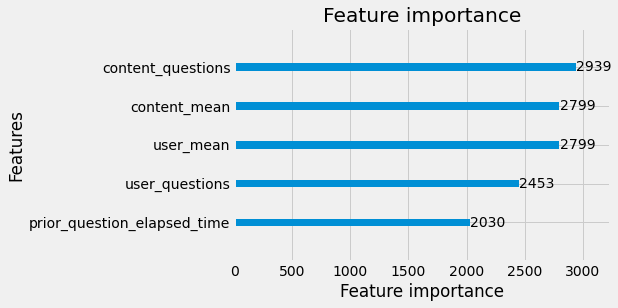

In [ ]:
lgb.plot_importance(model)
plt.show()

### Lets use the Competition API to bring in the test data and make a submission
https://www.kaggle.com/sohier/competition-api-detailed-introduction/notebook

In [ ]:
env = riiideducation.make_env()

In [ ]:
iter_test = env.iter_test()

In [ ]:
for (test_df, sample_prediction_df) in iter_test:
    test_df = test_df.merge(user_df, on = "user_id", how = "left")
    test_df = test_df.merge(content_df, on = "content_id", how = "left")
    test_df['content_questions'].fillna(0, inplace = True)
    test_df['content_mean'].fillna(0.5, inplace = True)
    test_df['watches_lecture'].fillna(0, inplace = True)
    test_df['user_questions'].fillna(0, inplace = True)
    test_df['user_mean'].fillna(0.5, inplace = True)
    test_df['prior_question_elapsed_time'].fillna(mean_prior, inplace = True)
    test_df['prior_question_had_explanation'].fillna(False, inplace = True)
    test_df['prior_question_had_explanation'] = label_enc.transform(test_df['prior_question_had_explanation'])
    test_df[['content_questions', 'user_questions']] = test_df[['content_questions', 'user_questions']].astype(int)
    test_df['answered_correctly'] =  model.predict(test_df[features])
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])

In [ ]:
#last batch overview
#submission_test_df = test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']]
#submission_test_df.to_csv('submission.csv')

In [ ]:
#submission_test_df.shape

In [ ]:
#submission_test_df